# Hyperparameter optimization to the radio resource scheduler using PPO RL

We create the radio resource scheduler environment using the [sixg_radio_mgmt](https://github.com/lasseufpa/sixg_radio_mgmt). We are replicating the same environment utilized in the [Lesson 1 notebook 3](../lesson_1/3-rl_agent_for_radio_resource_scheduler.ipynb), so you can check it for more details about the environment characteristic.

In [1]:
from pathlib import Path
import os
from tqdm import tqdm
from copy import deepcopy

import gymnasium as gym
import matplotlib.pyplot as plt
from ray import air, tune
import numpy as np
from ray.rllib.algorithms.ppo import PPOConfig
from ray.tune.schedulers import ASHAScheduler
from ray.rllib.algorithms.algorithm import Algorithm
from ray.tune.registry import register_env

# sixg_radio_mgmt
from sixg_radio_mgmt import (
    CommunicationEnv,
    Association,
    UEs,
    Channel,
    Mobility,
    Traffic,
    Agent,
)
from typing import Optional, Tuple, Union

## Radio resource scheduler simulator 

In [2]:
class SimpleAssociation(Association):
    def __init__(
        self,
        ues: UEs,
        max_number_ues: int,
        max_number_basestations: int,
        max_number_slices: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
        scenario_name: str = "",
    ) -> None:
        super().__init__(
            ues,
            max_number_ues,
            max_number_basestations,
            max_number_slices,
            rng,
            root_path,
            scenario_name,
        )
        self.basestation_ue_assoc = np.ones((1, max_number_ues), dtype=int)
        self.basestation_slice_assoc = np.ones((1, max_number_slices), dtype=int)
        self.slice_ue_assoc = np.ones((1, max_number_ues), dtype=int)

    def step(
        self,
        basestation_ue_assoc: np.ndarray,
        basestation_slice_assoc: np.ndarray,
        slice_ue_assoc: np.ndarray,
        slice_req: Optional[dict],
        step_number: int,
        episode_number: int,
    ) -> Tuple[np.ndarray, np.ndarray, np.ndarray, Optional[dict]]:
        return (
            basestation_ue_assoc,
            basestation_slice_assoc,
            slice_ue_assoc,
            slice_req,
        )

In [3]:
class SimpleChannel(Channel):
    def __init__(
        self,
        max_number_ues: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
        scenario_name: str = "",
    ) -> None:
        super().__init__(
            max_number_ues,
            max_number_basestations,
            num_available_rbs,
            rng,
            root_path,
            scenario_name,
        )
        self.current_episode_number = -1
        self.ues_mean_se = np.array([])
        self.default_std = 1.5

    def step(
        self,
        step_number: int,
        episode_number: int,
        mobilities: np.ndarray,
        sched_decision: Optional[np.ndarray] = None,
    ) -> np.ndarray:
        if episode_number != self.current_episode_number:
            self.current_episode_number = episode_number
            self.ues_mean_se = np.abs(
                self.rng.normal(5, 1, size=(self.max_number_ues,))
            )

        spectral_efficiencies = np.array(
            [
                np.ones((self.max_number_ues, self.num_available_rbs[i]))
                for i in np.arange(self.max_number_basestations)
            ]
        )
        for ue_idx, ue_mean in enumerate(self.ues_mean_se):
            spectral_efficiencies[0, ue_idx, :] = np.abs(
                self.rng.normal(
                    ue_mean,
                    self.default_std,
                    size=(self.num_available_rbs[0],),
                )
            )

        return spectral_efficiencies

In [4]:
class SimpleMobility(Mobility):
    def __init__(
        self,
        max_number_ues: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
    ) -> None:
        super().__init__(max_number_ues, rng, root_path)

    def step(self, step_number: int, episode_number: int) -> np.ndarray:
        return np.ones((self.max_number_ues, 2))

In [5]:
class SimpleTraffic(Traffic):
    def __init__(
        self,
        max_number_ues: int,
        rng: np.random.Generator = np.random.default_rng(),
        root_path: str = "",
    ) -> None:
        super().__init__(max_number_ues, rng, root_path)
        self.traffics_pattern = {
            "embb": {
                "num_ues": 3,
                "ue_throughput": 100,
            },
            "urllc": {
                "num_ues": 2,
                "ue_throughput": 10,
            },
        }

    def step(
        self,
        slice_ue_assoc: np.ndarray,
        slice_req: dict,
        step_number: int,
        episode_number: int,
    ) -> np.ndarray:
        traffic_per_ue = np.zeros(self.max_number_ues)

        # eMBB
        traffic_per_ue[0 : self.traffics_pattern["embb"]["num_ues"]] = (
            self.rng.poisson(
                self.traffics_pattern["embb"]["ue_throughput"],
                self.traffics_pattern["embb"]["num_ues"],
            )
            * 1e6
        )  # Mbps
        # URLLC
        traffic_per_ue[
            self.traffics_pattern["embb"]["num_ues"] : self.traffics_pattern["embb"][
                "num_ues"
            ]
            + self.traffics_pattern["urllc"]["num_ues"]
        ] = (
            self.rng.poisson(
                self.traffics_pattern["urllc"]["ue_throughput"],
                self.traffics_pattern["urllc"]["num_ues"],
            )
            * 1e6
        )  # Mbps

        return traffic_per_ue

## Defining scenario characteristics

In [6]:
seed = 10
number_ues = 5
number_basestations = 1
number_slices = 1
rbs_available = np.array([100])

steps_per_episode = 1000
training_episodes = 80
training_epochs = 1
testing_episodes = 20

## RL agent environment connection

The same used in [Lesson 1 notebook 3](../lesson_1/3-rl_agent_for_radio_resource_scheduler.ipynb).

In [7]:
class RLSimple(Agent):
    def __init__(
        self,
        env: CommunicationEnv,
        max_number_ues: int,
        max_number_slices: int,
        max_number_basestations: int,
        num_available_rbs: np.ndarray,
        hyperparameters: dict = {},
        seed: int = np.random.randint(1000),
    ) -> None:
        super().__init__(
            env,
            max_number_ues,
            max_number_slices,
            max_number_basestations,
            num_available_rbs,
            seed,
        )
        self.agent_name = "ray_ppo"
        self.current_obs = None

    def step(self, obs_space: Union[np.ndarray, dict]) -> np.ndarray:
        return np.array([])

    def obs_space_format(self, obs_space: dict) -> Union[np.ndarray, dict]:
        # Function that create the observations
        self.current_obs = obs_space
        formatted_obs_space = np.array([])
        hist_labels = [
            "buffer_occupancies",
            "spectral_efficiencies",
        ]
        for hist_label in hist_labels:
            if hist_label == "spectral_efficiencies":
                spectral_eff_ues = (
                    np.mean(obs_space[hist_label][0], axis=1) / 20
                )  # Normalizing by 20
                formatted_obs_space = np.append(
                    formatted_obs_space,
                    spectral_eff_ues,
                    axis=0,
                )
            else:
                formatted_obs_space = np.append(
                    formatted_obs_space, obs_space[hist_label], axis=0
                )
        return formatted_obs_space

    def calculate_reward(self, obs_space: dict) -> Union[float, dict]:
        reward = (
            np.sum(obs_space["pkt_effective_thr"], dtype=float) * 65536 / 1e6
        ) / 1000  # Achieved throughput in Mbps divided by 1000 for normalization
        return reward

    def action_format(
        self,
        action: Union[np.ndarray, dict],
    ) -> np.ndarray:
        # Function that generate the actions
        curr_action = deepcopy(action)
        assert isinstance(curr_action, np.ndarray), "Action must be a numpy array"
        assert isinstance(
            self.current_obs, dict
        ), "Observation space must be a dictionary"
        sched_decision = np.array(
            [
                np.zeros((self.max_number_ues, self.num_available_rbs[basestation]))
                for basestation in np.arange(self.max_number_basestations)
            ]
        )
        if np.sum(curr_action + 1) == 0:
            curr_action = np.ones_like(curr_action)
        rbs_per_ue = np.floor(
            self.num_available_rbs[0] * (curr_action + 1) / np.sum(curr_action + 1)
        )
        assert not np.isnan(rbs_per_ue).any(), "NaN values in action"
        while np.sum(rbs_per_ue) != self.num_available_rbs[0]:
            rbs_per_ue[0] += 1

        sched_decision = self.distribute_rbs_ues(
            rbs_per_ue,
            sched_decision,
            np.arange(self.max_number_ues),
            self.num_available_rbs,
            0,
        )

        assert (
            np.sum(sched_decision) == self.num_available_rbs[0]
        ), "Allocated RBs are different from available RBs"

        return sched_decision

    def get_action_space(
        self,
    ) -> gym.spaces.Box:
        return gym.spaces.Box(
            low=-1, high=1, shape=(self.max_number_ues,), dtype=np.float64
        )

    def get_obs_space(
        self,
    ) -> gym.spaces.Box:
        return gym.spaces.Box(
            low=0,
            high=np.inf,
            shape=(2 * self.max_number_ues,),
            dtype=np.float64,
        )

    def distribute_rbs_ues(
        self,
        rbs_per_ue: np.ndarray,
        allocation_rbs: np.ndarray,
        slice_ues: np.ndarray,
        rbs_per_slice: np.ndarray,
        slice_idx: int,
    ) -> np.ndarray:
        rb_idx = np.sum(rbs_per_slice[:slice_idx], dtype=int)
        for idx, ue_idx in enumerate(slice_ues):
            allocation_rbs[0, ue_idx, rb_idx : rb_idx + rbs_per_ue[idx].astype(int)] = 1
            rb_idx += rbs_per_ue[idx].astype(int)

        return allocation_rbs

When using a custom environment in Ray RLlib, a function that returns the environment needs to be created to register the environment using Ray API:

In [8]:
def env_creator(env_config, training=True):
    comm_env = CommunicationEnv(
        ChannelClass=SimpleChannel,
        TrafficClass=SimpleTraffic,
        MobilityClass=SimpleMobility,
        AssociationClass=SimpleAssociation,
        config_file="rrs_simple",
        simu_name="rrs_simple",
        agent_name="ray_ppo",
    )
    rl_api = RLSimple(
        comm_env,
        number_ues,
        number_slices,
        number_basestations,
        rbs_available,
    )
    comm_env.set_agent_functions(
        obs_space_format=rl_api.obs_space_format,
        action_format=rl_api.action_format,
        calculate_reward=rl_api.calculate_reward,
        obs_space=rl_api.get_obs_space(),
        action_space=rl_api.get_action_space(),
    )
    comm_env.max_number_episodes = 80 if training else 100

    return comm_env


register_env("comm_env", lambda config: env_creator(config))

## Defining the Tune config and RL agent

Here, we are optimizing the learning rate `lr` and the discount factor `gamma`.

In [9]:
search_space = {
    "lr": tune.loguniform(1e-5, 1),
    "gamma": tune.choice(
        [
            0.5,
            0.6,
            0.7,
            0.8,
            0.9,
            0.95,
            0.98,
            0.99,
            0.995,
            0.999,
            0.9999,
        ]
    ),
}

Similarly to [lesson 2 notebook 2](2-optimize_ppo_hyperparameters_cartpole.ipynb), we use a random search algorithm.

In [10]:
search_algo = tune.search.basic_variant.BasicVariantGenerator()  # Random search

In this example, we utilize an ASHA scheduler to stop unpromising trials (with bad performance).

In [11]:
scheduler_algo = ASHAScheduler(
    time_attr="timesteps_total",  # Metric to use for comparison
    max_t=1000 * training_episodes * training_epochs,  # Max time units per trial.
    grace_period=1000 * 12,  # Only stop trials at least this old in time.
    reduction_factor=3,  # Used to set halving rate and amount.
    brackets=1,  # Number of brackets. Each bracket has a different halving rate, specified by the reduction factor.
)  # ASHA trial scheduler

Once the search and scheduler algorithms are defined, we can define our Tune configuration:

In [12]:
number_trials = 50
tune_config = tune.TuneConfig(
    metric="env_runners/episode_reward_mean",  # That's the metric we want to maximize/minimize
    mode="max",  # Here we indicate we want to maximize the metric env_runners/episode_reward_mean
    scheduler=scheduler_algo,
    search_alg=search_algo,
    num_samples=number_trials,  # Number of trials to run
)

RL configuration to be used in the training.

In [13]:
config = PPOConfig().environment("comm_env")  # We utilize our registered environment
stop = {
    "timesteps_total": 1000 * training_episodes * training_epochs,
}
checkpoint_frequency = 0
store_results_path = str(Path("./ray_results/").resolve()) + "/nb_4/"
agent_name = "ppo_cartpole"

In the cell below, we first check if there is a stopped training by analysing the ray results folder. In case there is, the training is restored from the stopped point, in case not, a new training process is initialized from scratch. **when executing the cell below, stop the cell execution after some time, and execute the cell again to see the previous training being restored**.

In [14]:
if tune.Tuner.can_restore(f"{store_results_path+agent_name}/"):
    tuner = tune.Tuner.restore(
        f"{store_results_path+agent_name}/",
        trainable="PPO",
        param_space={
            **config.to_dict(),
            **search_space,
        },
        restart_errored=True,
        resume_errored=True,
        resume_unfinished=True,
    )
else:
    tuner = tune.Tuner(
        "PPO",
        param_space={
            **config.to_dict(),
            **search_space,
        },  # Here we mix the Algo config with the search space
        tune_config=tune_config,
        run_config=air.RunConfig(
            storage_path=store_results_path,
            name=agent_name,
            stop=stop,
            verbose=2,
            checkpoint_config=air.CheckpointConfig(
                checkpoint_frequency=checkpoint_frequency,
                checkpoint_at_end=True,
            ),
        ),
    )
results = tuner.fit()
print(results)

2024-11-30 17:42:10,100	WARNING experiment_analysis.py:180 -- Failed to fetch metrics for 28 trial(s):
- PPO_comm_env_9ccaa_00033: FileNotFoundError('Could not fetch metrics for PPO_comm_env_9ccaa_00033: both result.json and progress.csv were not found at /home/lasse/ray_minicourse/lesson_2/ray_results/nb_4/ppo_cartpole/PPO_comm_env_9ccaa_00033_33_gamma=0.9999,lr=0.3833_2024-11-30_17-36-22')
- PPO_comm_env_9ccaa_00045: FileNotFoundError('Could not fetch metrics for PPO_comm_env_9ccaa_00045: both result.json and progress.csv were not found at /home/lasse/ray_minicourse/lesson_2/ray_results/nb_4/ppo_cartpole/PPO_comm_env_9ccaa_00045_45_gamma=0.9800,lr=0.7465_2024-11-30_17-36-22')
- PPO_comm_env_9ccaa_00047: FileNotFoundError('Could not fetch metrics for PPO_comm_env_9ccaa_00047: both result.json and progress.csv were not found at /home/lasse/ray_minicourse/lesson_2/ray_results/nb_4/ppo_cartpole/PPO_comm_env_9ccaa_00047_47_gamma=0.9900,lr=0.0006_2024-11-30_17-36-22')
- PPO_comm_env_9ccaa_

2024-11-30 17:42:11,393	INFO tune_controller.py:444 -- Restoring the run from the latest experiment state file: experiment_state-2024-11-30_17-36-22.json
(PPO pid=549579) Install gputil for GPU system monitoring.
(PPO pid=549576) 2024-11-30 17:42:24,153	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future!
2024-11-30 17:42:24,300	ERROR tune_controller.py:1331 -- Trial task failed for trial PPO_comm_env_9ccaa_00018
Traceback (most recent call last):
  File "/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/_private/auto_init_hook.py", line 21, in auto_init_wrapper
    return fn(*args, **kwargs)
  File "/home/lasse/.local/share/virtual

Trial name,agent_timesteps_total,counters,custom_metrics,episode_media,info,num_agent_steps_sampled,num_agent_steps_sampled_lifetime,num_agent_steps_trained,num_env_steps_sampled,num_env_steps_sampled_lifetime,num_env_steps_sampled_this_iter,num_env_steps_sampled_throughput_per_sec,num_env_steps_trained,num_env_steps_trained_this_iter,num_env_steps_trained_throughput_per_sec,num_healthy_workers,num_in_flight_async_sample_reqs,num_remote_worker_restarts,num_steps_trained_this_iter,perf,timers
PPO_comm_env_9ccaa_00003,,,,,,,,,,,,,,,,,,,,,
PPO_comm_env_9ccaa_00008,,,,,,,,,,,,,,,,,,,,,
PPO_comm_env_9ccaa_00011,80000,"{'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",{},{},"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float32(0.63662285), 'cur_kl_coeff': np.float64(1.5187500000000005), 'cur_lr': np.float64(0.0016743308183117893), 'total_loss': np.float64(-0.019646353840387317), 'policy_loss': np.float64(-0.03288541355280466), 'vf_loss': np.float64(0.0047985937585303135), 'vf_explained_var': np.float64(0.4608461597914337), 'kl': np.float64(0.005557508340780777), 'entropy': np.float64(5.5348369101042385), 'entropy_coeff': np.float64(0.0)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(128.0), 'num_grad_updates_lifetime': np.float64(18135.5), 'diff_num_grad_updates_vs_sampler_policy': np.float64(464.5)}}, 'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",80000,80000,80000,80000,80000,4000,342.7754001535104,80000,4000,342.7754001535104,2,0,0,4000,"{'cpu_util_percent': np.float64(42.55625), 'ram_util_percent': np.float64(40.6)}","{'training_iteration_time_ms': 11663.827, 'restore_workers_time_ms': 0.021, 'training_step_time_ms': 11663.772, 'sample_time_ms': 3804.557, 'load_time_ms': 0.31, 'load_throughput': 12909522.93, 'learn_time_ms': 7854.206, 'learn_throughput': 509.281, 'synch_weights_time_ms': 4.129}"
PPO_comm_env_9ccaa_00013,,,,,,,,,,,,,,,,,,,,,
PPO_comm_env_9ccaa_00015,80000,"{'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",{},{},"{'learner': {'default_policy': {'learner_stats': {'allreduce_latency': np.float64(0.0), 'grad_gnorm': np.float32(2.0195985), 'cur_kl_coeff': np.float64(2.562890625), 'cur_lr': np.float64(0.0015099026260196847), 'total_loss': np.float64(-0.010464650817135329), 'policy_loss': np.float64(-0.03628306552787782), 'vf_loss': np.float64(0.0007237529629022785), 'vf_explained_var': np.float64(0.3932429491191782), 'kl': np.float64(0.009791546085816897), 'entropy': np.float64(4.770142106086977), 'entropy_coeff': np.float64(0.0)}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': np.float64(128.0), 'num_grad_updates_lifetime': np.float64(18135.5), 'diff_num_grad_updates_vs_sampler_policy': np.float64(464.5)}}, 'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",80000,80000,80000,80000,80000,4000,339.36880965085555,80000,4000,339.36880965085555,2,0,0,4000,"{'cpu_util_percent': np.float64(40.05882352941177), 'ram_util_percent': np.float64(39.48823529411764)}","{'training_iteration_time_ms': 11733.704, 'restore_workers_time_ms': 0.023, 'training_step_time_ms': 11733.646, 'sample_time_ms': 3832.734, 'load_time_ms': 0.324, 'load_throughput': 12353446.727, 'learn_time_ms': 7896.031, 'learn_throughput': 506.584, 'synch_weights_time_ms': 3.988}"
PPO_comm_env_9ccaa_00016,,,,,,,,,,,,,,,,,,,,,
PPO_comm_env_9ccaa_00017,,,,,,,,,,,,,,,,,,,,,
PPO_comm_env_9ccaa_00018,,,,,,,,,,,,,,,,,,,,,
PPO_comm_env_9ccaa_00020,80000,"{'num_env_steps_sampled': 80000, 'num_env_steps_trained': 80000, 'num_agent_steps_sampled': 80000, 'num_agent_steps_trained': 80000}",{},{},"{'learner': {'default_policy': {'learner_stats': 

(PPO pid=550506) Install gputil for GPU system monitoring. [repeated 5x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(PPO pid=549578) 2024-11-30 17:42:24,269	WARNING deprecation.py:50 -- DeprecationWarning: `ray.rllib.execution.train_ops.multi_gpu_train_one_step` has been deprecated. This will raise an error in the future! [repeated 4x across cluster]
2024-11-30 17:42:37,553	ERROR tune_controller.py:1331 -- Trial task failed for trial PPO_comm_env_9ccaa_00033
Traceback (most recent call last):
  File "/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/air/execution/_internal/event_manager.py", line 110, in resolve_future
    result = ray.get(future)
  File "/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/_private/auto

ResultGrid<[
  Result(
    metrics={'custom_metrics': {}, 'episode_media': {}, 'info': {'learner': {'default_policy': {'learner_stats': {'allreduce_latency': 0.0, 'grad_gnorm': np.float32(2.6274629), 'cur_kl_coeff': 0.4500000000000001, 'cur_lr': 0.0019439176753819239, 'total_loss': 0.03801830044737266, 'policy_loss': -0.03778768058025068, 'vf_loss': 0.06727514196467656, 'vf_explained_var': 0.08767898492915656, 'kl': 0.018957428378498963, 'entropy': 6.988489549903459, 'entropy_coeff': 0.0}, 'model': {}, 'custom_metrics': {}, 'num_agent_steps_trained': 128.0, 'num_grad_updates_lifetime': 2325.5, 'diff_num_grad_updates_vs_sampler_policy': 464.5}}, 'num_env_steps_sampled': 12000, 'num_env_steps_trained': 12000, 'num_agent_steps_sampled': 12000, 'num_agent_steps_trained': 12000}, 'env_runners': {'episode_reward_max': 320.4051107840003, 'episode_reward_min': 237.24693913599992, 'episode_reward_mean': 299.3947552426666, 'episode_len_mean': 1000.0, 'episode_media': {}, 'episodes_timesteps_tota

Sometimes, the combination of the learning rate and gamma may generate trials which obtain NaN outputs in the neural neutwork (usually due to a high learning rate value as explained [here](https://discuss.ray.io/t/error-nan-tensors-in-pytorch-with-ray-rllib-for-marl/8938)). Don't mind with these errored trials, since there are others with more appropriate values running.

When restoring a stopped training, some trials in the beggining may not have saved sufficient information to restore their execution. So, they will be restarted from scratch according to the options `restart_errored=True`, `resume_errored=True`, and `resume_unfinished=True`.

Now, let's take a look at the tensorboard data and visualize the `episode_reward_mean` metric to verify the performance of the different trials.

In [16]:
%load_ext tensorboard
%tensorboard --logdir ray_results/nb_4

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6007 (pid 556622), started 0:00:14 ago. (Use '!kill 556622' to kill it.)

Let's read the best trial checkpoint using the function `ExperimentAnalysis()`. We have used this function before but when training a unique trial. Now, considering multiple trials, this function can be used to compare all the trial results in relation to the `metric` utilized and select the best checkpoint of this trial.

In [42]:
analysis = tune.ExperimentAnalysis(store_results_path + agent_name)
assert analysis.trials is not None, "Analysis trial is None"
best_trial = analysis.get_best_trial(
    "env_runners/episode_reward_mean", "max"
)  # Get best trial
print(
    f"##############\nBest trial: {best_trial}, learning rate: {best_trial.config['lr']}, gamma: {best_trial.config['gamma']}\n################\n\n\n"
)
checkpoint = analysis.get_best_checkpoint(
    trial=best_trial,
    metric="env_runners/episode_reward_mean",
    mode="max",
)
tuner_agent = Algorithm.from_checkpoint(checkpoint)

##############
Best trial: PPO_comm_env_9ccaa_00021, learning rate: 0.0012434451605414067, gamma: 0.6
################





/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/rllib/algorithms/algorithm.py:557: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
`UnifiedLogger` will be removed in Ray 2.7.
  return UnifiedLogger(config, logdir, loggers=None)
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/site-packages/ray/tune/logger/unified.py:53: RayDeprecationWarning: This API is deprecated and may be removed in future Ray releases. You could suppress this warning by setting env variable PYTHONWARNINGS="ignore::DeprecationWarning"
The `JsonLogger interface is deprecated in favor of the `ray.tune.json.JsonLoggerCallback` interface and will be removed in Ray 2.7.
  self._loggers.append(cls(self.config, self.logdir, self.trial))
/home/lasse/.local/share/virtualenvs/ray_minicourse-PTDOXG61/lib/python3.10/

You can take a look at the tensorboard visualization to the metric `env_runners/episode_reward_mean` and verify that the selected trial above is exactly the trial with the best performance in the graph.

We can use the read best trial agent and test it in the environment. 

In [43]:
comm_env = env_creator({}, training=False)
obs, _ = comm_env.reset(
    seed=seed, options={"initial_episode": 80}
)  # Initial observation
for episode in tqdm(range(testing_episodes * 1000)):
    action = tuner_agent.compute_single_action(  # Here we compute the action using the trained agent
        obs,
        explore=False,
    )
    assert isinstance(action, np.ndarray), "Action must be a numpy array"
    obs, reward, terminated, truncated, info = comm_env.step(
        action
    )  # Applying the action in the environment
    if terminated:
        comm_env.reset()

100%|██████████| 20000/20000 [00:36<00:00, 548.48it/s]


The cell below plot the results obtained in the episode 80 of the test results.

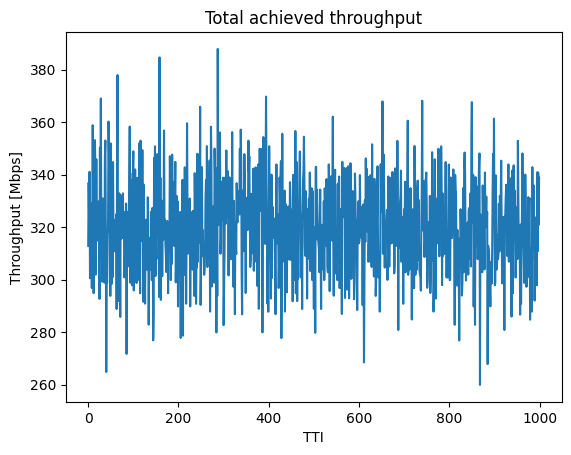

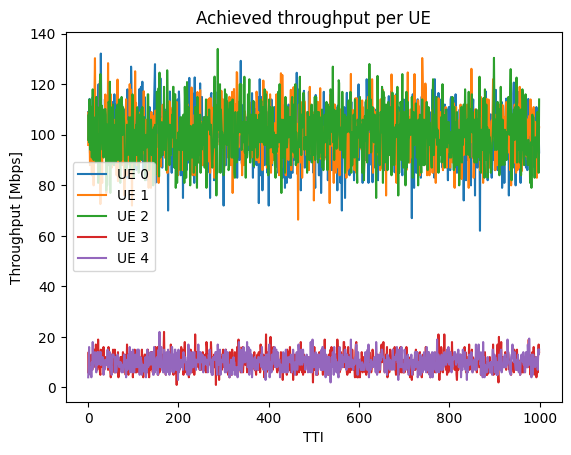

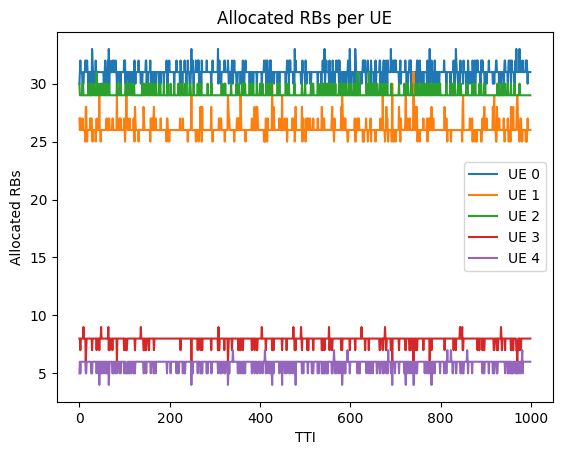

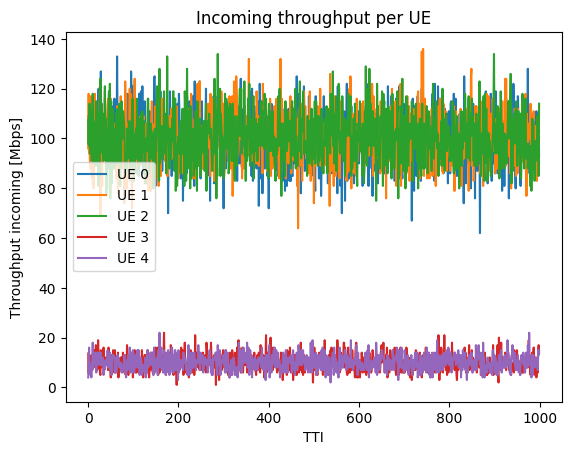

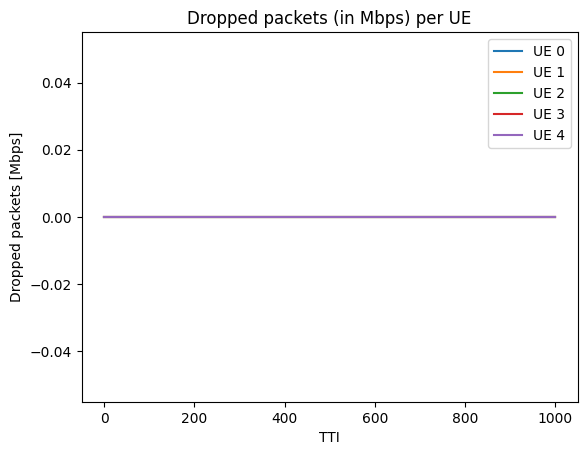

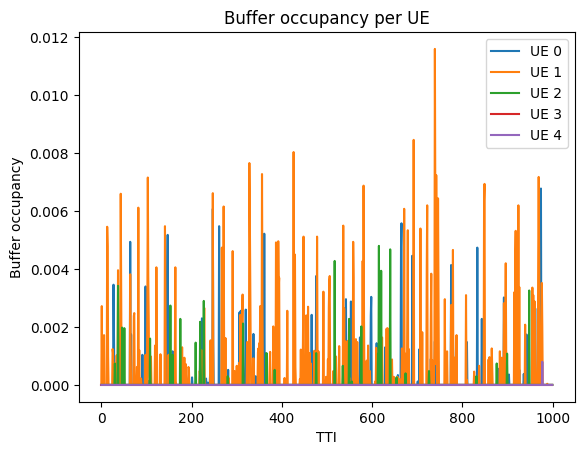

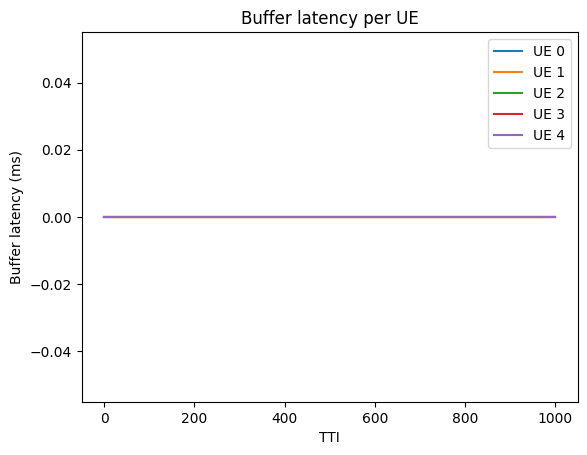

Total throughput achieved: 320234.979328


In [44]:
hist_ep_80 = np.load("hist/rrs_simple/ray_ppo/ep_80.npz")
pkt_size = 65536  # Default packet size in bits
effective_throughput = hist_ep_80["pkt_effective_thr"] * pkt_size / 1e6
pkt_incoming = hist_ep_80["pkt_incoming"] * pkt_size / 1e6
dropped_pkts = hist_ep_80["dropped_pkts"] * pkt_size / 1e6
buffer_occupancies = hist_ep_80["buffer_occupancies"]
total_throughput = np.sum(effective_throughput, axis=1)
rbs_per_ue = np.squeeze(hist_ep_80["sched_decision"]).sum(axis=2)

# Total achieved throughput
plt.figure()
plt.plot(total_throughput, label="Total throughput")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.title("Total achieved throughput")
plt.show()

# Achieved throughput per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(effective_throughput[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Throughput [Mbps]")
plt.legend()
plt.title("Achieved throughput per UE")
plt.show()

# RBs per UE
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(rbs_per_ue[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Allocated RBs")
plt.legend()
plt.title("Allocated RBs per UE")
plt.show()

# Pkt incoming
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(pkt_incoming[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Throughput incoming [Mbps]")
plt.legend()
plt.title("Incoming throughput per UE")
plt.show()

# Dropped packets
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(dropped_pkts[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Dropped packets [Mbps]")
plt.legend()
plt.title("Dropped packets (in Mbps) per UE")
plt.show()

# Buffer occupancies
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(buffer_occupancies[:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Buffer occupancy")
plt.legend()
plt.title("Buffer occupancy per UE")
plt.show()

# Buffer latencies
plt.figure()
for ue_idx in np.arange(number_ues):
    plt.plot(hist_ep_80["buffer_latencies"][:, ue_idx], label=f"UE {ue_idx}")
plt.xlabel("TTI")
plt.ylabel("Buffer latency (ms)")
plt.title("Buffer latency per UE")
plt.legend()
plt.show()

print(f"Total throughput achieved: {np.sum(total_throughput)}")